## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2023.

# Assignment 1, Task 3: Multilayer Perceptron (MLP)
This is the third part of the assignment. You will get to implement MLP using tensorflow

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import pickle

from tensorflow.keras.datasets import fashion_mnist

# Plot configurations
%matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

## Load Data

In [2]:
# Load the raw Fashion-MNIST data.
train, test = fashion_mnist.load_data()

X_train_raw, y_train = train
X_test_raw, y_test = test

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_test = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1]**2))

# Data organizations:
# Train data: 58000 samples from original training set of 60,000
# Validation data: 2000 samples from original training set: 58,000~60,000
# Test data: 10000 samples from original test set
# Development data (for gradient check): 100 from the training set

num_training = 58000
num_validation = 2000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(58000, 784) (2000, 784) (10000, 784) (100, 784)
Train data shape:  (58000, 784)
Train labels shape:  (58000,)
Validation data shape:  (2000, 784)
Validation labels shape:  (2000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)
Development data shape: (100, 784)
Development data shape (100,)


## Part 1: Tensorflow MLP (10%)
In this part, you will use tensorflow modules to implement an MLP. We provide a demo of a two-layer net, the style of is referenced from https://www.tensorflow.org/guide/keras and https://www.tensorflow.org/guide/eager. 

You need to implement a MLP with 4 layers in a similar style.

### Demo: Two-layer MLP in Tensorflow

In [3]:
## Demo: Two-layer net in tensorflow (eager execution mode)
hidden_dim = 300
reg_tf = tf.constant(0.01)

# define a tf.keras.Model class
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.W1 = tf.Variable(1e-2*np.random.rand(X_train.shape[1], hidden_dim).astype('float32'))
        self.b1 = tf.Variable(np.zeros((hidden_dim,)).astype('float32'))
        self.W2 = tf.Variable(1e-2*np.random.rand(hidden_dim, 20).astype('float32'))
        self.b2 = tf.Variable(np.zeros((20,)).astype('float32'))
    def call(self, inputs):
        """Run the model."""
        h1 = tf.nn.relu(tf.matmul(inputs, self.W1) + self.b1)
        out = tf.matmul(h1, self.W2) + self.b2
        return out

# Define and calculate loss function (Note that in eager execution, loss must be in a function)
def loss(model, inputs, targets, reg = tf.constant(0.01)):
    out = model(inputs)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= out, labels=tf.one_hot(targets,20))
    L2_loss = tf.nn.l2_loss(model.W1) + tf.nn.l2_loss(model.W2)
    return tf.reduce_mean(cross_entropy) + reg * L2_loss

# calculate gradients for all variables using tf.GradientTape
def grad(model, inputs, targets, reg = tf.constant(0.01)):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, reg=reg)
    return tape.gradient(loss_value, [model.W1, model.b1, model.W2, model.b2])

# calculate classification accuracy
def eval_acc(model, inputs, targets):
    correct_prediction = tf.equal(targets, tf.cast(tf.argmax(model(inputs),1), tf.uint8))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

num_train = 58000
batch_size = 500
num_batch = num_train//batch_size
num_epochs = 15
model = Model()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

for e in range(num_epochs):
    for i in range(num_batch):
        batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        x_tf = tf.Variable(batch_xs, dtype = tf.float32)
        y_tf = tf.Variable(batch_ys, dtype = tf.uint8)
        
        grads = grad(model, x_tf, y_tf, reg_tf)
        #optimization based on calculated gradients 
        optimizer.apply_gradients(zip(grads, [model.W1, model.b1, model.W2, model.b2]))

    x_tf = tf.Variable(X_val, dtype = tf.float32)
    y_tf = tf.Variable(y_val, dtype = tf.uint8)
    accuracy = eval_acc(model, x_tf, y_tf)
    val_acc = accuracy.numpy()
    print('epoch {}: valid acc = {}'.format(e+1, val_acc))

x_tf = tf.Variable(X_test, dtype = tf.float32)
y_tf = tf.Variable(y_test, dtype = tf.uint8)
accuracy = eval_acc(model, x_tf, y_tf)
test_acc = accuracy.numpy()
print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.7394999861717224
epoch 2: valid acc = 0.7799999713897705
epoch 3: valid acc = 0.8149999976158142
epoch 4: valid acc = 0.8320000171661377
epoch 5: valid acc = 0.8429999947547913
epoch 6: valid acc = 0.8514999747276306
epoch 7: valid acc = 0.8539999723434448
epoch 8: valid acc = 0.8585000038146973
epoch 9: valid acc = 0.8629999756813049
epoch 10: valid acc = 0.8665000200271606
epoch 11: valid acc = 0.8700000047683716
epoch 12: valid acc = 0.8744999766349792
epoch 13: valid acc = 0.8730000257492065
epoch 14: valid acc = 0.8740000128746033
epoch 15: valid acc = 0.8725000023841858
test acc = 0.8600999712944031


### Create Deeper Network

<span style="color:red"><strong>TODO</strong></span>: Create your MLP in tensorflow. Since you are going to create a deeper neural network, it is recommended to use "list" to store your network parameters (weights and bias). Consider using a loop to create your MLP network.

<span style="color:red"><strong>HINT</strong></span>: Copy the code above and make necessary changes in model definition.

In [8]:
import numpy as np
import tensorflow as tf

# Define the deeper MLP model
class DeeperMLP(tf.keras.Model):
    def __init__(self, input_dim, hidden_dims=[400, 300, 200], num_classes=20, weight_scale=1e-2):
        super(DeeperMLP, self).__init__()

        self.layer_weights = []
        self.layer_biases = []
        
        layers_dim = [input_dim] + hidden_dims + [num_classes]
        
        for i in range(len(layers_dim) - 1):
            W_init = tf.initializers.GlorotUniform()  # Glorot Uniform initialization
            W = tf.Variable(W_init(shape=(layers_dim[i], layers_dim[i+1])))
            
            b = tf.Variable(tf.zeros([layers_dim[i+1]]))
            
            self.layer_weights.append(W)
            self.layer_biases.append(b)

    def call(self, inputs):
        for i in range(len(self.layer_weights) - 1):
            inputs = tf.nn.relu(tf.matmul(inputs, self.layer_weights[i]) + self.layer_biases[i])
        return tf.matmul(inputs, self.layer_weights[-1]) + self.layer_biases[-1]

# Define and calculate loss function 
def loss(model, inputs, targets, reg=tf.constant(0.01)):
    out = model(inputs)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=out, labels=tf.one_hot(targets,20))
    
    L2_loss = sum([tf.nn.l2_loss(w) for w in model.layer_weights])
    
    return tf.reduce_mean(cross_entropy) + reg * L2_loss

# Calculate gradients for all variables using tf.GradientTape
def grad(model, inputs, targets, reg=tf.constant(0.01)):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, reg=reg)
    return tape.gradient(loss_value, model.layer_weights + model.layer_biases)

# Calculate classification accuracy
def eval_acc(model, inputs, targets):
    correct_prediction = tf.equal(targets, tf.cast(tf.argmax(model(inputs),1), tf.uint8))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

num_train = 58000
batch_size = 500
num_batch = num_train//batch_size
num_epochs = 15
model = DeeperMLP(input_dim=X_train.shape[1], hidden_dims=[400, 300, 200], num_classes=20)
optimizer = tf.keras.optimizers.SGD(learning_rate=5e-3)

for e in range(num_epochs):
    for i in range(num_batch):
        batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        x_tf = tf.Variable(batch_xs, dtype=tf.float32)
        y_tf = tf.Variable(batch_ys, dtype=tf.uint8)
        
        grads = grad(model, x_tf, y_tf, reg_tf)
        
        # Optimization based on calculated gradients 
        optimizer.apply_gradients(zip(grads, model.layer_weights + model.layer_biases))

    x_tf = tf.Variable(X_val, dtype=tf.float32)
    y_tf = tf.Variable(y_val, dtype=tf.uint8)
    accuracy = eval_acc(model, x_tf, y_tf)
    val_acc = accuracy.numpy()
    print('epoch {}: valid acc = {}'.format(e+1, val_acc))

x_tf = tf.Variable(X_test, dtype=tf.float32)
y_tf = tf.Variable(y_test, dtype=tf.uint8)
accuracy = eval_acc(model, x_tf, y_tf)
test_acc = accuracy.numpy()
print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.7774999737739563
epoch 2: valid acc = 0.8059999942779541
epoch 3: valid acc = 0.8174999952316284
epoch 4: valid acc = 0.8224999904632568
epoch 5: valid acc = 0.828000009059906
epoch 6: valid acc = 0.8349999785423279
epoch 7: valid acc = 0.8370000123977661
epoch 8: valid acc = 0.8385000228881836
epoch 9: valid acc = 0.8420000076293945
epoch 10: valid acc = 0.8450000286102295
epoch 11: valid acc = 0.843500018119812
epoch 12: valid acc = 0.8454999923706055
epoch 13: valid acc = 0.843500018119812
epoch 14: valid acc = 0.8464999794960022
epoch 15: valid acc = 0.8479999899864197
test acc = 0.8434000015258789


## Part 2: Introduction to TensorFlow.keras (10%)

As you can see, when the network structure becomes larger, it is hard to handle variables from every layer. Here we introduce the `tf.keras` tool to build the network in a much simpler way. You may want to use it in your project.

<span style="color:red"><strong>TODO</strong></span>: Follow this official example: https://www.tensorflow.org/datasets/keras_example#step_2_create_and_train_the_model to build an MLP and train it. 

*You should keep the same optimizer (SGD) and loss function (cross entropy) as in the previous task.*

**Note:** Since we want to use our own dataset, we will not use the `tfds.load` method to load the data this time. 

You need to check the usage of [`model.fit()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) and feed the model with our own data.

**Tips:**
* Softmax is also registered as a layer operation in tf.keras.
* You can use `model.summary()` to visualize the model after you build it.
* Use `verbose=2` in `model.fit()` to get similar training logs

In [12]:
#############################################################
# TODO: build the model with tf.keras.models.Sequential
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(X_train.shape[1],)),
    
    tf.keras.layers.Dense(400, activation='relu'),
    tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    
    tf.keras.layers.Dense(20, activation='softmax')
])
# END of your code
#############################################################



#############################################################
# TODO: compile the model, set optimizer and loss
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=5e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)
# END of your code
#############################################################



#############################################################
# TODO: train the model with our own dataset
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=30,
    batch_size=500,
    validation_data=(X_val, y_val),
    verbose=2
)
# END of your code
#############################################################
# loss, acc = model.evaluate(X_test, y_test, verbose=2)
# print('\nModel Test accuracy:', acc)

Epoch 1/30
116/116 - 1s - loss: 7.5213 - accuracy: 0.7084 - val_loss: 0.7490 - val_accuracy: 0.7695 - 551ms/epoch - 5ms/step
Epoch 2/30
116/116 - 0s - loss: 0.6035 - accuracy: 0.8051 - val_loss: 0.6313 - val_accuracy: 0.7900 - 447ms/epoch - 4ms/step
Epoch 3/30
116/116 - 0s - loss: 0.4879 - accuracy: 0.8333 - val_loss: 0.5654 - val_accuracy: 0.8015 - 469ms/epoch - 4ms/step
Epoch 4/30
116/116 - 0s - loss: 0.4307 - accuracy: 0.8494 - val_loss: 0.5329 - val_accuracy: 0.8135 - 456ms/epoch - 4ms/step
Epoch 5/30
116/116 - 0s - loss: 0.3911 - accuracy: 0.8617 - val_loss: 0.5127 - val_accuracy: 0.8255 - 446ms/epoch - 4ms/step
Epoch 6/30
116/116 - 0s - loss: 0.3637 - accuracy: 0.8696 - val_loss: 0.5052 - val_accuracy: 0.8220 - 452ms/epoch - 4ms/step
Epoch 7/30
116/116 - 0s - loss: 0.3394 - accuracy: 0.8775 - val_loss: 0.4940 - val_accuracy: 0.8265 - 448ms/epoch - 4ms/step
Epoch 8/30
116/116 - 0s - loss: 0.3217 - accuracy: 0.8842 - val_loss: 0.4959 - val_accuracy: 0.8335 - 444ms/epoch - 4ms/step


## Part 3: t-SNE (5%)

**t-SNE** is is a machine learning algorithm for nonlinear dimensionality reduction developed by *Geoffrey Hinton* and *Laurens van der Maaten*. It can be used as a good way of visualizing high-dimensional data in 2D.

Here we show its application for CIFAR100. Later it will be re-used in a CNN network. Experimenting with t-SNE can be fun. One thing to try is to visualize the output of each layer of MLP to observe the differences.

In [13]:
from utils.train_funcs import train, test
from utils.classifiers.mlp import MLP

In [14]:
# Load the raw Fashion-MNIST data.
train_data, test_data = fashion_mnist.load_data()

X_train_raw, y_train = train_data
X_test_raw, y_test = test_data

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_test = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1]**2))

# Data organizations:
# Train data: 58000 samples from original training set of 60,000
# Validation data: 2000 samples from original training set: 58,000~60,000
# Test data: 10000 samples from original test set
# Development data (for gradient check): 100 from the training set
num_training = 58000
num_validation = 2000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(58000, 784) (2000, 784) (10000, 784) (100, 784)
Train data shape:  (58000, 784)
Train labels shape:  (58000,)
Validation data shape:  (2000, 784)
Validation labels shape:  (2000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)
Development data shape: (100, 784)
Development data shape (100,)


### t-SNE of Original Data

In [4]:
!pip install scikit-learn

<font color="red">**NOTE**</font>: You may have to restart the kernel before proceeding.

it takes 0.9298670291900635 seconds


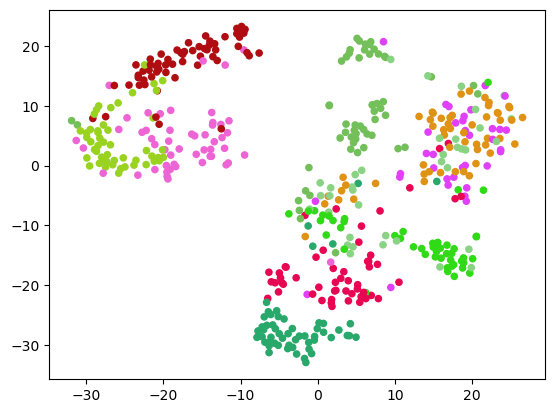

In [16]:
from sklearn.manifold import TSNE

random_select = np.random.choice(10000, 500, replace=False)
X = X_test_raw[random_select,:,:].reshape(500,X_train.shape[1]).astype('float')/255.0

tic = time.time()
Y = TSNE(n_components=2, perplexity=25.0).fit_transform(X)
print("it takes {} seconds".format(time.time()-tic))

## visualize tSNE of original data
labels = y_test[random_select]
colors = np.random.rand(20,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

### t-SNE of Data After Two Hidden Layers

Do visualization of the tSNE of data after going through MLP. In the visualization result, you should find that in comparison with the t-SNE of original data where all data points mess up with each other. Visualization of data after two-layer networks would be shown as multiple clusters in a 2D panel.

In [17]:
# Define MLP model
model = MLP(input_dim=X_train.shape[1], hidden_dims=[100], num_classes=20, reg=0.1, weight_scale=1e-3)

num_epoch = 10
batch_size = 200
lr = 1e-3
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 290
epoch 1: valid acc = 0.814, new learning rate = 0.00095
epoch 2: valid acc = 0.8435, new learning rate = 0.0009025
epoch 3: valid acc = 0.861, new learning rate = 0.000857375
epoch 4: valid acc = 0.861, new learning rate = 0.0008145062499999999
epoch 5: valid acc = 0.8585, new learning rate = 0.0007737809374999998
epoch 6: valid acc = 0.875, new learning rate = 0.0007350918906249997
epoch 7: valid acc = 0.872, new learning rate = 0.0006983372960937497
epoch 8: valid acc = 0.868, new learning rate = 0.0006634204312890621
epoch 9: valid acc = 0.878, new learning rate = 0.000630249409724609
epoch 10: valid acc = 0.882, new learning rate = 0.0005987369392383785
test acc: 0.8695


0.8695

<span style="color:red"><strong>TODO</strong></span>: Visualize data that is passed through MLP model defined above using tSNE. 

In [21]:
# run tSNE
tic = time.time()

#############################################################################
#                          START OF YOUR CODE                               #
# Hint: Pass data through affine and dense layers (model.layers) and then 
# apply softmax to obtain output of the MLP model.
#############################################################################
def get_hidden_layer_output(model, X):
    layer1_out = model.layers[0].feedforward(X)
    layer2_out = model.layers[1].feedforward(layer1_out)
    return layer2_out

X_hidden = get_hidden_layer_output(model, X_train)

# Extract features from the last hidden layer
X_hidden = get_hidden_output(model, X_train)
tsne = TSNE(n_components=2, random_state=123)
X_tsne = tsne.fit_transform(X_hidden)

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

print("it takes {} seconds".format(time.time()-tic))

it takes 102.21879816055298 seconds


it takes 204.57260632514954 seconds


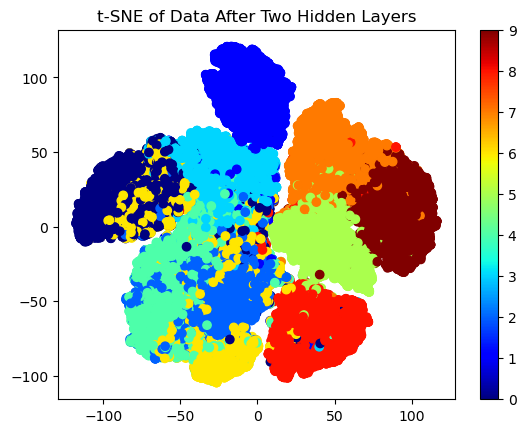

In [22]:
# visualize tSNE 2D representation of data after two hidden layers
#############################################################################
#                          START OF YOUR CODE                               #
# Hint: See tSNE visualization of original data
#############################################################################
tsne = TSNE(n_components=2, random_state=123)
X_tsne = tsne.fit_transform(X_hidden)

print("it takes {} seconds".format(time.time()-tic))

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap='jet')
plt.colorbar()
plt.title("t-SNE of Data After Two Hidden Layers")
plt.show()
#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

<span style="color:red"><strong>TODO</strong></span>: Try tuning the parameters of t-SNE. Do visualization of the new t-SNE of data.

In [23]:
# Tune the parameter, show the results.
# run tSNE
tic = time.time()

#############################################################################
#                          START OF YOUR CODE                               #
#############################################################################
perplexity_value = 30
learning_rate_value = 200
early_exaggeration_value = 12.0

tsne = TSNE(n_components=2, perplexity=perplexity_value, learning_rate=learning_rate_value, 
            early_exaggeration=early_exaggeration_value, random_state=42)
X_tsne = tsne.fit_transform(X_hidden_output)

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

print("it takes {} seconds".format(time.time()-tic))

it takes 96.61889505386353 seconds


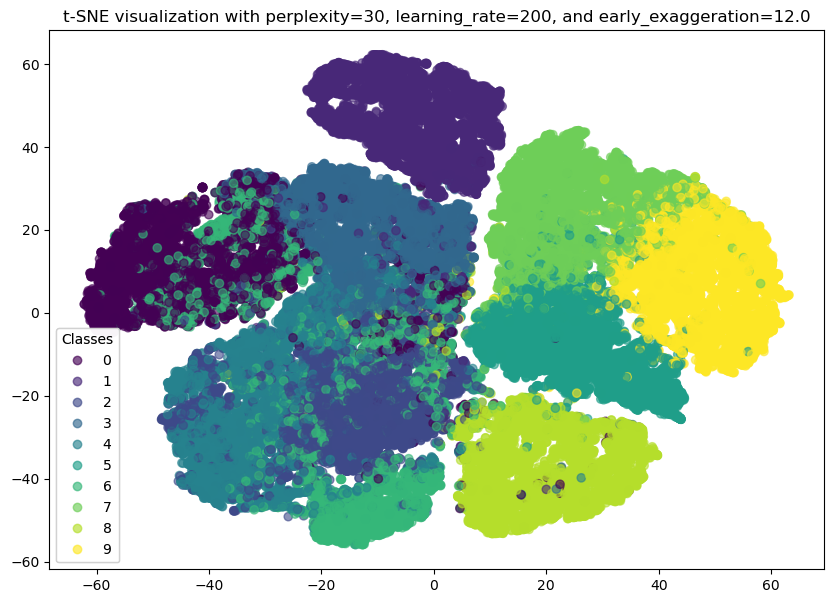

In [24]:
# visualize tSNE 2D representation of data after two hidden layers
#############################################################################
#                          START OF YOUR CODE                               #
#############################################################################
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_train, cmap='viridis', alpha=0.6)
legend1 = plt.legend(*scatter.legend_elements(), title="Classes")
plt.gca().add_artist(legend1)
plt.title(f"t-SNE visualization with perplexity={perplexity_value}, learning_rate={learning_rate_value}, and early_exaggeration={early_exaggeration_value}")
plt.show()

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################